# Google PageRank

## Implementacija Algoritma 3.1 :

In [2]:
import numpy as np
# sknetwork as skn
#from sknetwork.visualization import svg_graph
from IPython.display import SVG
from scipy.sparse import csr_matrix
#from sknetwork.ranking import PageRank

In [3]:
def permute_matrix(A, groups):
  out_degrees = A.sum(axis=1)  # Sum of each row

  dangling_nodes = np.where(out_degrees == 0)[0]  # Indices of dangling nodes

  non_dangling_nodes = np.where(out_degrees != 0)[0]

  permutation = np.concatenate([non_dangling_nodes, dangling_nodes])

  permutation_inverse = [0] * len(permutation)
  for i in range(len(permutation)):
    permutation_inverse[permutation[i]] = i
  for t in range(len(groups)):
    for i in range(len(groups[t])):
      groups[t][i] = permutation_inverse[groups[t][i]]

  permuted_matrix = A[permutation, :][:, permutation]

  return (permuted_matrix,permutation, permutation_inverse, groups)

In [4]:
def compute_pagerank(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, maxiter = 10000):

    # za faktor alpha za PageRank obično se uzima 0.85
    # za v (personalization vector) default je uniformna distribucija
    # za w (dangling node vector) također

    # dimenzija matrice H, tj. broj redaka i stupaca, tj. broj web-stranica (vrhova)
    n = H.shape[0]  # ovo računa broj redaka, jer je H.shape uređeni par broja redaka i broja stupaca
    if v is None:
        v = np.ones(n) / n
    if w is None:
        w = np.ones(n) / n
    #H,P = permute_matrix(H,[])

    # detekcija nul-redaka matrice H - onih koji odgovaraju dangling vrhovima
    row_sums = H.sum(axis = 1)
    nondangling_nodes = np.where(row_sums > 0)[0]
    dangling_nodes = np.where(row_sums == 0)[0]

    # ==> računanje vektora d
    d = np.zeros(n)
    d[dangling_nodes] = 1

    S = H + np.outer(d, w)
    # normalizacija stupaca matrice S, da bi S bila stupčano stohastička
    S /= S.sum(axis = 1)

    # ==> računanje Google matrice G za dane alpha i v
    e = np.ones(n)
    G = alpha * S + (1 - alpha) * np.outer(e, v)


    # Metoda potencija na G^
    sigma = np.ones(G.shape[0]) / G.shape[0]
    while maxiter > 0:
        maxiter -= 1
        new_sigma = sigma @ G
        new_sigma /= sum(new_sigma)
        # provjera uvjeta konvergencije
        if np.linalg.norm((new_sigma.T @ G  - new_sigma).T, 1) < epsilon: # za metriku koristimo normu_1 vektora
            sigma = new_sigma
            break
        #new_sigma[-1] = 1 - sum(new_sigma[:-1])
        sigma = new_sigma

    # Dobivanje PageRank vektora iz sigme
    pi = np.zeros(n)
    pi = sigma

    #print((pi @ G).T) # transpose
    #print(sum(pi))
    return pi


In [5]:
def permutation_matrix(H): #makes a permutation matrix when there is only one dangling group
  P= np.array([([0]*H.shape[0]) for i in range(H.shape[0])])
  #print(P)
  for i in range(H.shape[0]):
    if sum(H[i]) == 0 and sum(P[i]) == 0:
      t = False
      for j in range(H.shape[0] - 1, i, -1):
        if sum(H[j]) > 0 and sum(P[j]) == 0:
          P[j][i] = 1
          P[i][j] = 1
          t = True
          break
      if t == False:
        P[i][i] = 1
    elif sum(P[i]) == 0:
      P[i][i] = 1
  return P




In [6]:
def compute_pagerank_with_lumping_multiple_groups(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, maxiter = 100, groups = None):

    # za faktor alpha za PageRank obično se uzima 0.85
    # za v (personalization vector) default je uniformna distribucija
    # za w (dangling node vector) također

    # dimenzija matrice H, tj. broj redaka i stupaca, tj. broj web-stranica (vrhova)
    n = H.shape[0]  # ovo računa broj redaka, jer je H.shape uređeni par broja redaka i broja stupaca
    if v is None:
        v = np.ones(n) / n
    if w is None and groups is None:
        w = [ np.ones(n) / n]
    elif w is None:
      w = [np.ones(n) / n] * len(groups)

    w = [np.array(wi) for wi in w]
    v = np.array(v)
    # detekcija nul-redaka matrice H - onih koji odgovaraju dangling vrhovima
    row_sums = H.sum(axis = 1)
    nondangling_nodes = np.where(row_sums > 0)[0]
    dangling_nodes = np.where(row_sums == 0)[0]
    k = len(nondangling_nodes)

    if groups is None:
      groups = [dangling_nodes]
    m = len(groups)
    S = H
    prev = k
    S = S.astype(float)
    for i in range(m):
      for j in range(len(groups[i])):
        S[prev + j][:] = w[i][:]
      prev += len(groups[i])
    # normalizacija redaka matrice S, da bi S bila retčano stohastička

    S_SUM = S.sum(axis = 1)
    S /=  S_SUM[:, np.newaxis]
    # ==> računanje Google matrice F za dane alpha i v
    e = np.ones(n)
    F = alpha * S + (1 - alpha) * np.outer(e, v)


    # Metoda potencija na F^(1)

    sigma = np.ones(k + m ) / (k + m)
    new_sigma = np.zeros(k + m)
    while maxiter > 0:
        maxiter -= 1
        temp = np.zeros(k)
        for i in range(m):
          temp += sigma[k + i]* w[i][:k]
        new_sigma[:k] = alpha * (sigma[:k] @ S[:k,:k]) + (1-alpha)*v[:k] + alpha * temp   #sigma 1:k

        previous_group_ind = k
        for i in range(m):
          temp = 0
          prev = k
          for j in range(m):
            len_group = len(groups[j])
            temp += sigma[k + j] * (alpha * w[j][prev: prev + len_group] + (1-alpha) * v[prev: prev + len_group]) @ np.ones(len_group).T
            prev += len_group
          new_sigma[k + i] = temp + sigma[:k]@(alpha * S[:k,previous_group_ind: previous_group_ind + len(groups[i])] + (1-alpha)* np.ones(k).reshape(k,1) @  v[previous_group_ind: previous_group_ind + len(groups[i])].reshape(1,len(groups[i])))@np.ones(len(groups[i])).T
          previous_group_ind += len(groups[i])

        # provjera uvjeta konvergencije
        if np.linalg.norm((sigma  - new_sigma/sum(new_sigma)), 1) < epsilon: # za metriku koristimo normu_1 vektora
            sigma = new_sigma/sum(new_sigma)
            break
        sigma = new_sigma/sum(new_sigma)

    # Dobivanje PageRank vektora iz sigme
    pi = np.zeros(n)
    pi[:k] = sigma[:k]
    segment = [t for t in range(k)]
    for t in groups:
      segment.append(t[0])
    F_pi = F[segment,k:]
    pi = sigma[:k]
    pi = np.append(pi,sigma @ F_pi)
    #print(np.linalg.norm( (pi - pi.T@F), 1))
    return (pi,(pi.T @ F).T)

In [7]:
A = np.array([[0, 1, 1, 1, 0, 1],
              [0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]])

H,P,P_inv,groups = permute_matrix(A, [[5],[3,1]])
#print(groups)

#pi = compute_pagerank_with_lumping_multiple_groups(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, groups = groups, maxiter = 1000)
pi, pi_check = compute_pagerank_with_lumping_multiple_groups(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, groups = None, maxiter = 1000)
print(pi[P_inv])

[0.2189943  0.20581693 0.14050285 0.14050282 0.15368026 0.14050282]


In [8]:
import time
n = 15000
p_s = [0.9, 0.8, 0.7, 0.6, 0.5 , 0.4, 0.3, 0.2, 0.1]
time_optim = np.zeros(len(p_s))
time_no_optim =  np.zeros(len(p_s))
for pos in range(len(p_s)):
  A = np.zeros((n,n))
  k = np.random.binomial(n=1, p=p_s[pos], size=[n])
  for i in range(n):
    if k[i] == 1:
      A[i][:] = np.random.binomial(n=1, p=0.7, size=[n])
  H,P,P_inv,groups = permute_matrix(A, [])
  begin = time.time()
  pi,pi_check = compute_pagerank_with_lumping_multiple_groups(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, groups = None, maxiter = 100)
  time_optim[pos] = time.time() - begin
  begin = time.time()
  PI_no = compute_pagerank(H, alpha = 0.85, v = None, w = None, epsilon = 1e-6, maxiter = 100)
  time_no_optim[pos] = time.time() - begin




[ 7.98609972 18.97761273 20.60768008 15.74318099 12.0698421  11.91678143
 18.56074286 24.96551108 21.78090334]
[48.02252388 54.34553576 52.79217052 20.23048973 20.83545637 20.97254896
 53.59272361 50.36083055 39.25282335]


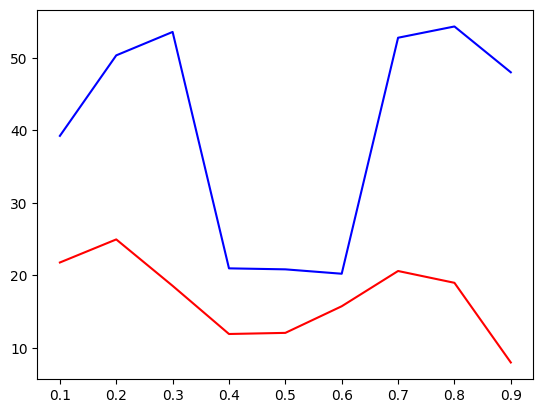

In [14]:
import matplotlib.pyplot as plt

print(time_optim)
print(time_no_optim)
x = p_s[::-1]
plt.plot(x, time_optim[::-1], color = 'r')
plt.plot(x, time_no_optim[::-1], color = 'b')
plt.show()